In [8]:
import pandas as pd
import numpy as np
from scipy import sparse as sps

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [9]:
site = 'aftonbladet'
articles = pd.read_pickle('201609/201609_aftonbladet_articles.pickle')

print('{} articles with item_id from {} to {}'.format(articles.shape[0], articles.item_id.min(), articles.item_id.max()))
articles.head()

3468 articles with item_id from 18 to 9083


,id,categories,title,published,lead,body,tags,article_id,item_id
item_id,,,,,,,,,
63,23422525@abse,"[frölunda, sportbladet, plus-lås in]",Djupanalys: ”Bomb som kan brisera...”,2016-09-01 07:20:17,<p>Sportbladets Hans Abrahamsson fortsätter at...,ABRAHAMSSONS ANALYS: Risk för baksmälla i Göte...,"[#plussport, frölunda indians, shl 2016/2017, ...",23422525,63
74,23432064@abse,"[övriga landslag, sportbladet, fotboll, landslag]",Ska bryta trend på 2 850 meters höjd,2016-09-01 13:04:53,<p>Tre raka bortamatcher utan seger.</p><p>Nu ...,"De kommer från ett OS-guld på hemmaplan, så de...",[],23432064,74
61,23412795@abse,"[nyheter, startsidan]",God morgon! Det här hände medan du sov,2016-09-01 02:34:12,"<p><span class=""abSymbFy2""></span> Börja dagen...",Uppgifter: Så tog sig mordmisstänkta paret til...,[],23412795,61
79,23435140@abse,"[nyheter, plus-lås in]",Flygande teleskopet kan se det osynliga,2016-09-01 09:19:57,<p>Det kallas för Vampyrplanet för att det bar...,Följ Aftonbladet Plus på Facebook Det SOFIA se...,[],23435140,79
81,23435638@abse,"[ehsan fadakar, startsidan]",De lurar dig och du fördummar dina vänner,2016-09-01 13:26:56,<p>En nyhetsvärld som drivs fram av algoritmer...,"Megyn Kelly, en 45-årig rapp, härdad programle...","[flashback, facebook, sociala medier]",23435638,81


In [10]:
from IPython.core.display import HTML, display
import pandas as pd
from scipy.stats import rankdata

pd.set_option('display.width', 1000)

from scipy import spatial

def embeddings_to_distances(embeddings):
    item_item_distances = pd.DataFrame(
        index=embeddings.index,
        columns=embeddings.index,
        data=spatial.distance.squareform(spatial.distance.pdist(embeddings.values, metric='cosine'))
    )
    return item_item_distances

def topn_most_similar(item_id, topn, item_item_distances):
    candidate_distances = item_item_distances.loc[item_id]
    return candidate_distances.sort_values().iloc[1:(topn+1)].to_frame('distance')

def display_items(from_id, to_items_df, articles):
    COLS = ['categories', 'tags', 'title', 'published']
    display(HTML(articles.loc[[from_id]][COLS].to_html()))
    display(HTML(to_items_df.join(articles[COLS]).to_html()))
    
def display_topn_most_similar(item_id, distances, topn=5, articles=articles):
    most_similar = topn_most_similar(item_id, topn, distances)
    display_items(item_id, most_similar, articles)
    
from sklearn.manifold import * 

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

def two_dim_plots(item_embeddings, sub_cats, articles=articles):
    two_dim_embeddings = pd.DataFrame(
        index=item_embeddings.index,
        data=TSNE().fit_transform(item_embeddings.values),
        columns=['x', 'y'])

    articles = articles.assign(sub_cat=lambda df: [c.encode('ascii', 'replace') for c in df.category])

    f = sns.lmplot('x', 'y',  data=two_dim_embeddings.join(articles), 
                   hue='sub_cat', palette=sns.color_palette("Set1", n_colors=len(sub_cats), desat=1),
                   fit_reg=False, scatter_kws={"marker": "D", "s": 20}, size=10)
    
    g = sns.lmplot('x', 'y',  data=two_dim_embeddings.join(articles), 
                   hue='published_date', palette=sns.light_palette("navy", n_colors=20, reverse=True),
                   fit_reg=False, scatter_kws={"marker": "D", "s": 20}, size=10)
    
    return f, g

## Building item features

In [11]:
from sklearn import preprocessing
from itertools import chain

def array_column_to_features(item_id, row, column):
    return [(item_id, u'{}={}'.format(column, value.replace(' ', '_'))) for value in row[column]]

def to_features(item_id, row, column):
    return [(item_id, u'{}={}'.format(column, row[column]))]

article_features = pd.DataFrame.from_records(
    data=chain.from_iterable(
        array_column_to_features(item_id, row, 'categories') + to_features(item_id, row, 'article_id')
                        for item_id, row in articles.set_index('item_id').iterrows()),
    columns=['item_id', 'feature'])

features_encoder = preprocessing.LabelEncoder()

article_features = article_features \
    .assign(encoded_feature=lambda df: features_encoder.fit_transform(df.feature)) \
    
article_features.head()

,item_id,feature,encoded_feature
0,63,categories=frölunda,3524
1,63,categories=sportbladet,3647
2,63,categories=plus-lås_in,3617
3,63,article_id=23422525,29
4,74,categories=övriga_landslag,3696


In [12]:
def to_coo(df, row_column, col_column, shape=None, dtype=np.float32):
    return sps.coo_matrix((np.ones_like(df[row_column]), 
                           (df[row_column], df[col_column].values)), dtype=dtype, shape=shape)

article_id_mask = article_features.feature.str.startswith('article_id')
all_cat_mask = article_features.feature.str.startswith('categor')

id_only_features = to_coo(article_features[article_id_mask], row_column='item_id', col_column='encoded_feature')
print('articles encoded into a {}'.format(id_only_features.__repr__()))

cat_and_id_features = to_coo(article_features, row_column='item_id', col_column='encoded_feature')
print('articles encoded into a {}'.format(cat_and_id_features.__repr__()))

category_features = to_coo(article_features[all_cat_mask], row_column='item_id', col_column='encoded_feature')
print('articles encoded into a {}'.format(category_features.__repr__()))

articles encoded into a <9084x3468 sparse matrix of type '<type 'numpy.float32'>'
	with 3468 stored elements in COOrdinate format>
articles encoded into a <9084x3698 sparse matrix of type '<type 'numpy.float32'>'
	with 10468 stored elements in COOrdinate format>
articles encoded into a <9084x3698 sparse matrix of type '<type 'numpy.float32'>'
	with 7000 stored elements in COOrdinate format>


## Views

In [13]:
views = pd.read_pickle('201609/201609_{}_views.pickle'.format(site))

print('{} views on {}x{} unique users/items ranging from {} to {}'.format(
        views.shape[0], views.user_id.nunique(), views.item_id.nunique(),
        views.timestamp.min(), views.timestamp.max()))

views.head()

32576979 views on 285629x3468 unique users/items ranging from 2016-09-01 00:21:47 to 2016-09-30 23:59:53


,timestamp,user_id,item_id
1130,2016-09-01 00:30:01,366409,18
2371,2016-09-01 00:46:21,107695,28
3606,2016-09-01 00:30:35,366409,25
5021,2016-09-01 00:30:52,366409,24
5380,2016-09-01 00:21:47,74185,18


In [14]:
def article_views_to_daily_counts(rows):
    article_views_ts = pd.Series(
        index=rows.timestamp,
        data=np.ones_like(rows.timestamp, dtype=int))
    return article_views_ts.resample('1D').sum()

article_hourly_views = views.groupby('item_id').apply(article_views_to_daily_counts)\
    .to_frame('n_views').reset_index()

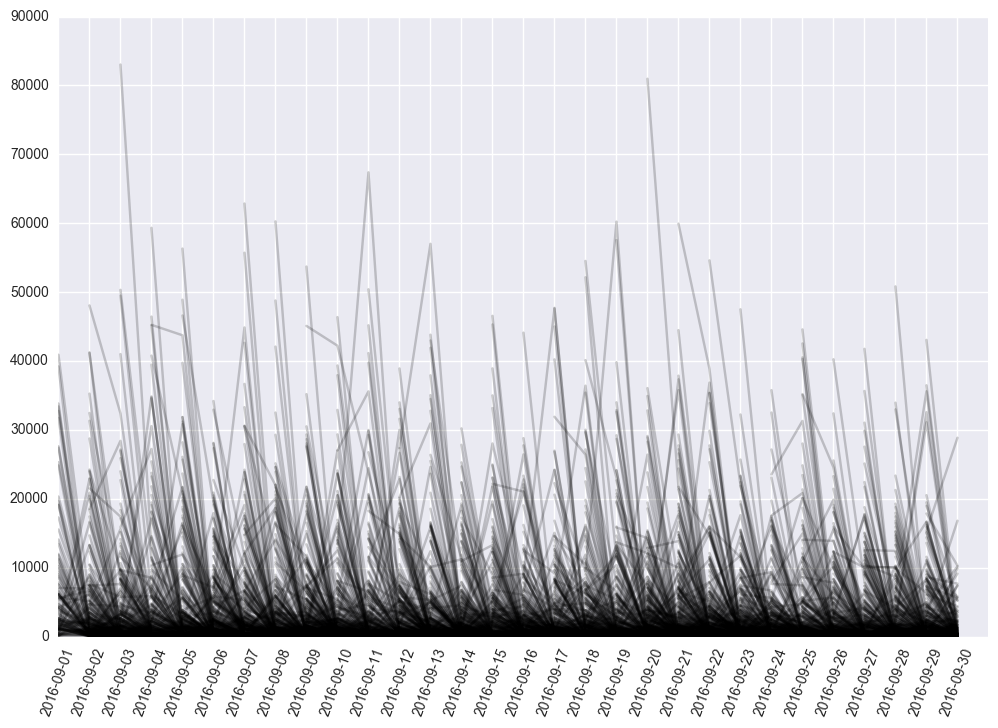

In [15]:
article_hourly_views_matrix = article_hourly_views.pivot(index='item_id', columns='timestamp', values='n_views')

plt.figure(figsize=(12, 8))
plt.plot(article_hourly_views_matrix.values.T, 'k-', alpha=.2);
plt.xticks(np.arange(article_hourly_views_matrix.shape[1]), article_hourly_views_matrix.columns.date, rotation=70);

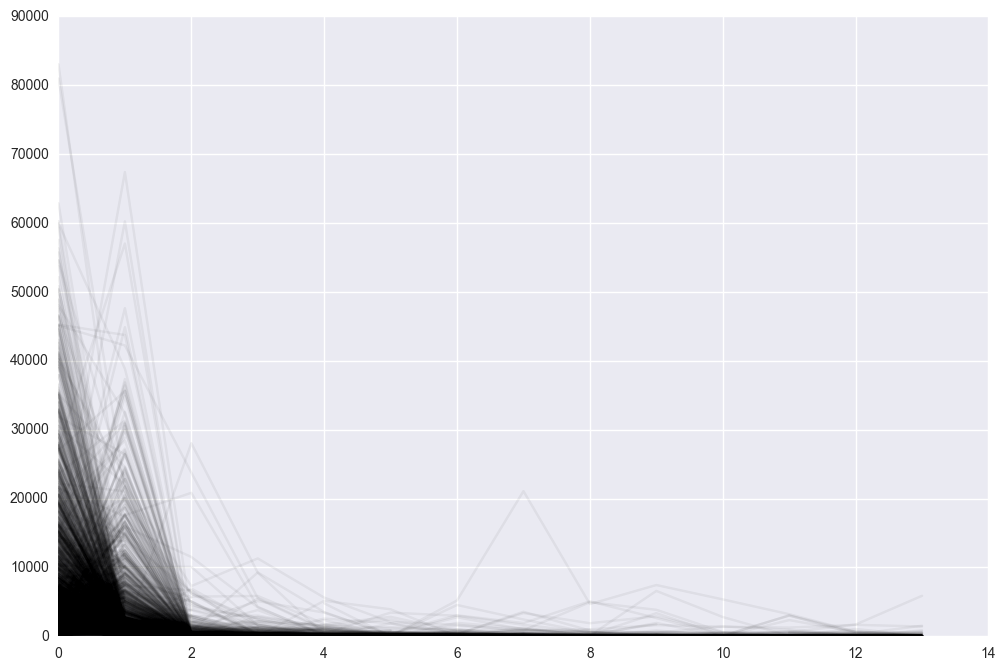

In [16]:
def aligned_views(row):
    first_non_null_index = np.where(~row.isnull())[0][0]
    return np.append(row.values[first_non_null_index:], np.repeat(np.nan, row.shape[0] - first_non_null_index))
    
article_aligned_hourly_views_matrix = pd.DataFrame(
    index=article_hourly_views_matrix.index,
    data=[aligned_views(row) for _, row in article_hourly_views_matrix.iterrows()])

plt.figure(figsize=(12, 8))
plt.plot(article_aligned_hourly_views_matrix.values[:, :14].T, 'k-', alpha=.05);

In [17]:
# 1min
days_visited_by_users = views.sample(1000000).assign(date=lambda df: df.timestamp.dt.date.astype('category'))\
    .groupby('user_id')['date'].nunique().to_frame('n_visited_days')

days_visited_by_users.head()

,n_visited_days
user_id,
1,4
2,3
4,1
5,3
7,1


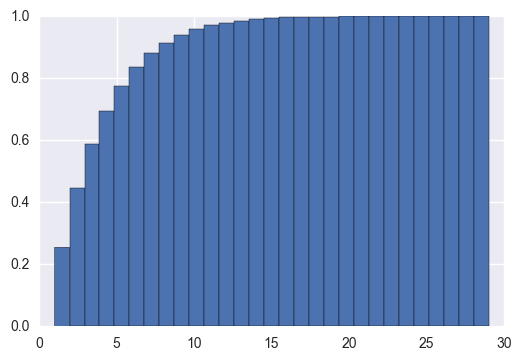

In [18]:
plt.hist(days_visited_by_users.values, bins=29, normed=True, cumulative=1);

In [19]:
train_df = views\
    .query("timestamp > '2016-09-12' and timestamp < '2016-09-19 00:00:00'")\
#    .sample(10000000)

train = to_coo(
    train_df, row_column='user_id', col_column='item_id')

test_df = views\
    .query("timestamp > '2016-09-20 00:00:00' and timestamp < '2016-09-21'")\
    .sample(100000)
    
test_know_user_df = test_df[test_df.user_id.isin(train_df.user_id.unique())]
test_know_user_and_item_df = test_know_user_df[test_know_user_df.item_id.isin(train_df.item_id.unique())]

test = to_coo(
    test_know_user_and_item_df,
    row_column='user_id', col_column='item_id', shape=train.shape)

data = dict(train=train, test=test)
print('train events encoded into a {}'.format(train.__repr__()))
print('test events encoded into a {}'.format(test.__repr__()))

train events encoded into a <416991x5518 sparse matrix of type '<type 'numpy.float32'>'
	with 7452864 stored elements in COOrdinate format>
test events encoded into a <416991x5518 sparse matrix of type '<type 'numpy.float32'>'
	with 4522 stored elements in COOrdinate format>


## ALS click based embeddings

In [20]:
import implicit

train = to_coo(
    train_df, row_column='user_id', col_column='item_id', dtype=np.double)

user_factors_values, item_factors_values = implicit.alternating_least_squares(train, factors=20, regularization=.01, iterations=10)

empty_factors_mask = np.all(item_factors_values == 0, 1)

als_item_factors = pd.DataFrame(
    index=np.where(~empty_factors_mask)[0],
    data=item_factors_values[~empty_factors_mask, :]
)

als_item_item_distances = embeddings_to_distances(als_item_factors)

print(als_item_factors.shape)
als_item_factors.head()

ImportError: No module named implicit

In [21]:
sport_article = 18
road_traffic = 3451
clinton_pass_out = 3811

In [22]:
display_topn_most_similar(item_id=sport_article, distances=als_item_item_distances)

NameError: name 'als_item_item_distances' is not defined

In [23]:
display_topn_most_similar(item_id=road_traffic, distances=als_item_item_distances)

NameError: name 'als_item_item_distances' is not defined

In [24]:
display_topn_most_similar(item_id=clinton_pass_out, distances=als_item_item_distances)

NameError: name 'als_item_item_distances' is not defined

In [25]:
subset_cats = [u'innenriks', u'meninger', u'verden', u'nyheter', u'osloby', u'kultur', u'nyheter', u'økonomi', 'politikk', 'a-magasinet']
ab_main_categories = [u'nyheter', u'sportbladet', u'startsidan', u'nöjesbladet', u'plus-lås_in']

def first_in_pool(cats, pool=subset_cats):
    candidates = (c for c in cats if c in pool)
    return next(candidates, 'other')

articles = articles\
    .assign(category=lambda df: [first_in_pool(cats, ab_main_categories) for cats in df.categories.values])\
    .assign(published_date=lambda df: df.published.dt.day)\

In [26]:
trained_articles = train_df.groupby('item_id').size().to_frame('views').query('views > 1000')
trained_articles.shape

(853, 1)

In [27]:
two_dim_plots(item_embeddings=als_item_factors.loc[trained_articles.index], sub_cats=ab_main_categories, articles=articles);

NameError: name 'als_item_factors' is not defined

## Item embeddings through Word2vec

In [28]:
user_to_items = train_df\
    .groupby('user_id')['item_id'].apply(np.array)

class UserHistorySentences(object):
    def __init__(self, user_to_items, n_samples=None):
        self.user_to_items = user_to_items
        self.n_samples = n_samples
 
    def __iter__(self):
        sampled_user_to_items = self.user_to_items.sample(self.n_samples) if self.n_samples else self.user_to_items 
        for user_id, item_ids in sampled_user_to_items.iteritems():
            yield item_ids.astype(str).tolist()

In [30]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=UserHistorySentences(user_to_items), size=20, window=100, iter=5, min_count=1, workers=4)

w2v_item_factors = pd.DataFrame(
    index=np.array(model.index2word).astype(np.int64),
    data=model.syn0)

print(w2v_item_factors.shape)
w2v_item_factors.head()

(1949, 20)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
3699,2.002517,-0.343883,6.790138,8.113278,-3.811354,-3.630102,8.851113,-2.324518,-1.580930,3.223119,-2.615557,0.903754,-1.059476,-1.249593,-2.550226,-0.346008,-5.141523,-1.031786,2.795048,4.027691
5221,-3.943196,-8.742287,-0.893274,0.487460,0.887384,-2.944937,-2.337095,3.243575,1.638887,-10.100936,2.617985,-3.172723,4.882299,1.521659,2.101174,0.733317,0.764992,-0.454753,-2.589819,-6.522909
4959,0.592231,-1.523617,-0.495453,1.952962,0.198882,-3.396834,-1.736875,2.206339,-1.389737,-10.186909,4.910637,-2.205040,5.548024,6.947065,0.137816,4.337872,-0.030655,-1.532829,-2.110173,-4.696816
5362,-0.219961,-9.792275,-7.686390,-6.970135,0.224877,-1.050555,-5.918014,5.479527,5.212565,-15.784507,0.252110,-2.871597,2.361206,-0.652975,5.870558,-0.387296,2.580155,-2.112572,-0.334703,-8.720570
3946,2.083071,1.022058,5.953938,8.216371,1.058118,-2.570313,2.505733,1.035344,-2.220609,3.490086,2.632797,2.249974,0.621631,0.283860,-1.367755,-3.306166,-1.917631,0.590098,1.056986,2.419674


In [31]:
w2v_item_item_distances = embeddings_to_distances(w2v_item_factors)

In [32]:
display_topn_most_similar(item_id=sport_article, distances=w2v_item_item_distances)

,categories,tags,title,published
item_id,,,,
18,"[dagens bästa spel, plus-lås in]","[#plussport, spel, trav]",Dagens drag: ”Brukar trivas mot motståndet”,2016-09-30 06:00:00


,distance,categories,tags,title,published
25,0.011580,"[topptipset, powerplay-förslag, plus-lås in]",[spel],Topptipset: ”Borde förbättra sin position”,2016-09-30 05:27:00
28,0.032199,"[bomben-förslag, plus-lås in]","[bomben (spel), spel]",Bomben: ”Samlat på sig en del poäng...”,2016-09-30 06:00:00
19,0.045019,"[lången & bomben, sportbladet spel, plus-lås in]",[spel],"Hetaste matcherna på Lången – säkra, draget oc...",2016-09-30 05:01:00
4915,0.145662,"[stryktipset, plus-lås in]",[],Fyra lag som alla kommer att vinna,2016-09-16 15:15:17
24,0.155294,"[powerplay-förslag, plus-lås in]","[#plussport, spel, powerplay (spel)]",Powerplay: ”Blandar sig nog med i toppen”,2016-09-30 05:35:00


In [33]:
display_topn_most_similar(item_id=road_traffic, distances=w2v_item_item_distances)

,categories,tags,title,published
item_id,,,,
3451,"[nyheter, startsidan]","[tågtrafik, uppsala]",Spårfel orsakade förseningar och inställda tåg,2016-09-12 05:11:17


,distance,categories,tags,title,published
3168,0.273765,[nyheter],[],God morgon! Det här hände medan du sov,2016-09-11 02:52:47
2760,0.301829,[mat & vin],[],Serverar öl med smak av granskott och gaffatejp,2016-09-09 14:22:09
3290,0.303283,"[nyheter, startsidan]",[],Storbrand på grekiska turistön,2016-09-11 19:21:36
1931,0.314434,"[landslaget, sportbladet, fotboll, landslag, v...","[herrlandslaget i fotboll, kvalet till fotboll...",Franska sågningen: ’Ett sorgligt Sverige’,2016-09-07 09:45:28
3470,0.323531,"[nyheter, startsidan]","[trafik, trafikolyckor, hisingen]",Två bilar i kö-krock i Göteborg,2016-09-12 06:55:54


In [34]:
display_topn_most_similar(item_id=clinton_pass_out, distances=w2v_item_item_distances)

,categories,tags,title,published
item_id,,,,
3811,"[nyheter, startsidan]","[hillary clinton, presidentvalet i usa 2016]",Clinton åkte till dottern för att undvika skva...,2016-09-13 19:55:03


,distance,categories,tags,title,published
3901,0.235540,"[eva franchell, ledare]","[hillary clinton, presidentvalet i usa 2016]",Hatet mot Hillary Clinton påminner om Mona Sahlin,2016-09-13 13:21:00
4370,0.253579,"[nyheter, startsidan, usa-valet 2016]","[hillary clinton, donald trump, usa, president...",Hillarys svar på sjuksmockan: Detaljerat läkar...,2016-09-14 22:38:01
3897,0.262783,[nöjesbladet],"[tro, hopp och kärlek]",Singelprästen berättar om pinsamma dejten,2016-09-13 18:57:42
3958,0.263389,"[nyheter, startsidan]","[göran hägglund, politik, anna ekström]",Hägglund om sin ”På spåret”-partner: Har svårs...,2016-09-13 15:30:08
3894,0.275522,[kultur],"[hillary clinton, donald trump]",Allt är inte kvinnohat,2016-09-13 12:22:00


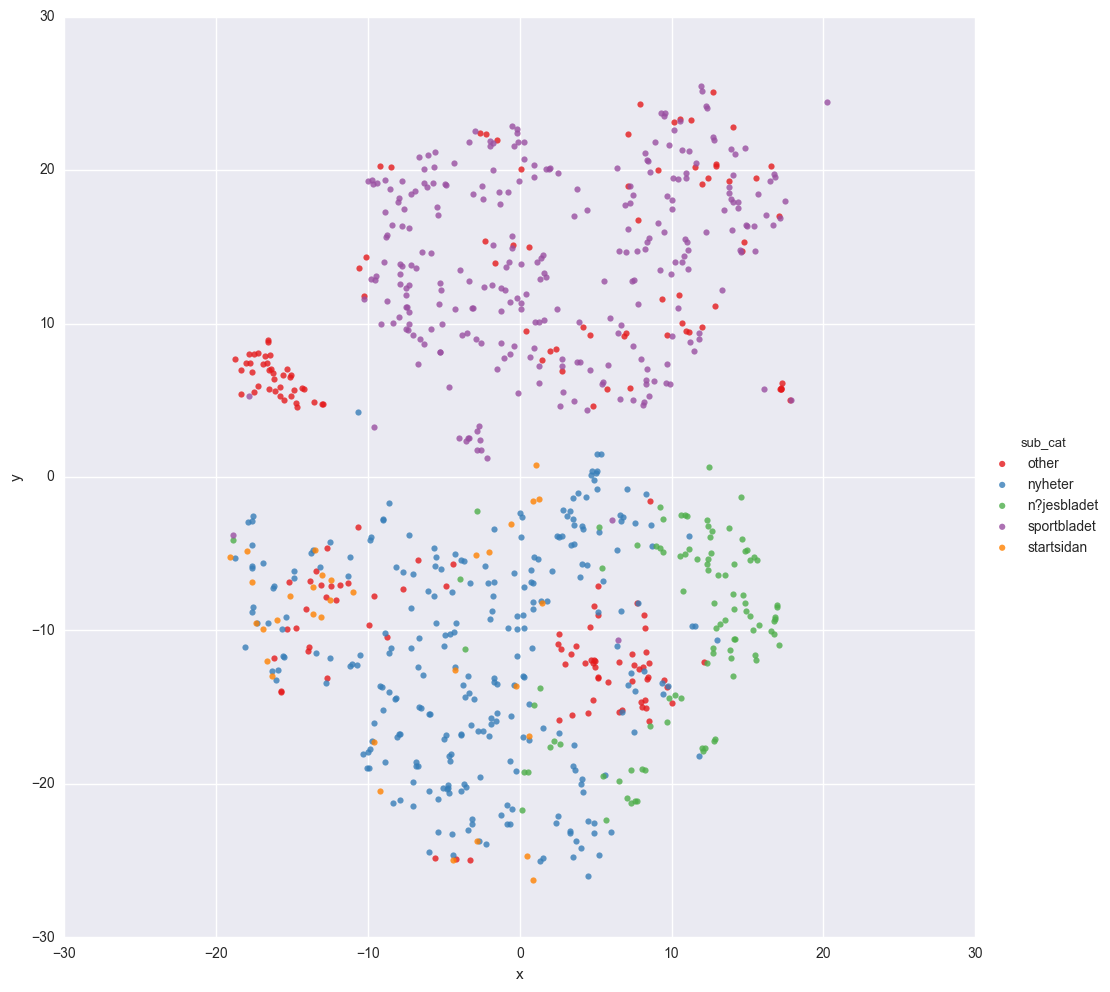

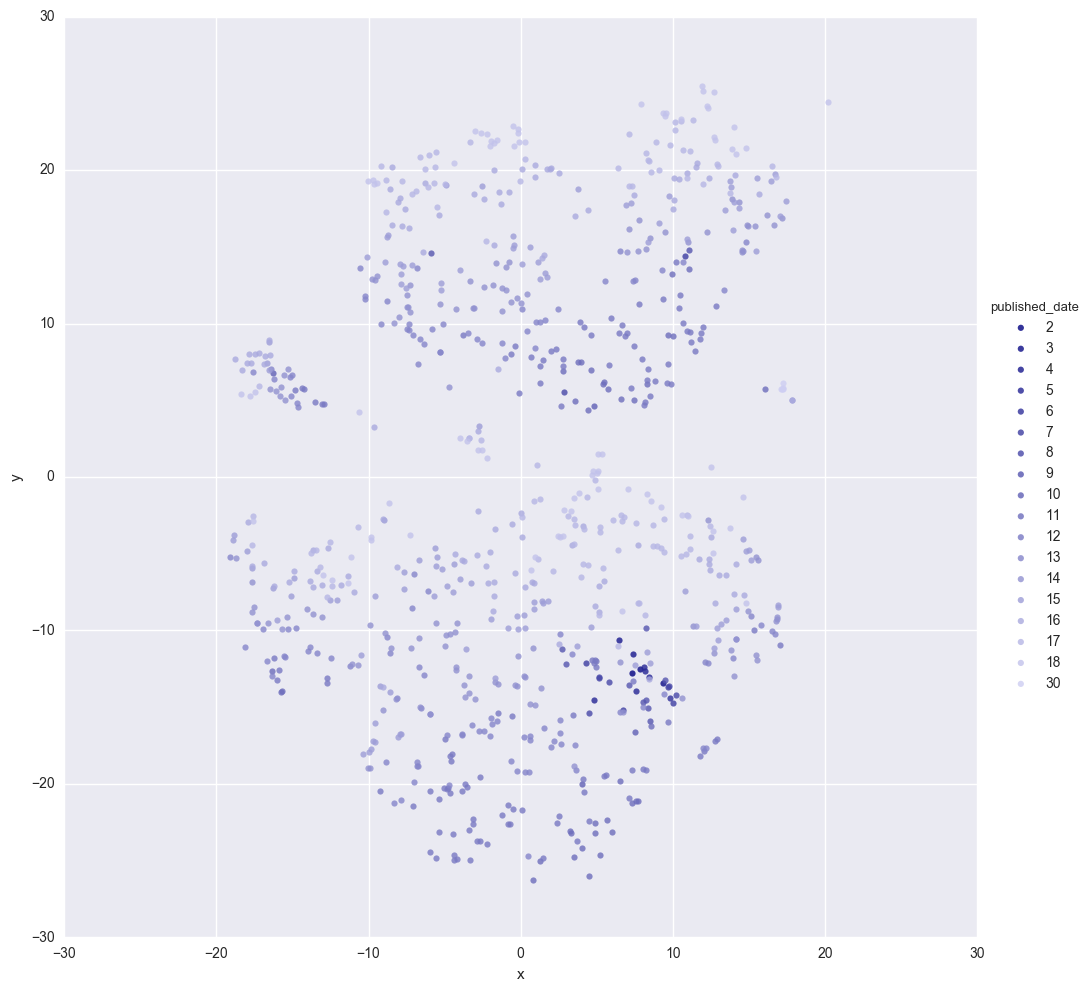

In [35]:
two_dim_plots(item_embeddings=w2v_item_factors.loc[trained_articles.index], sub_cats=ab_main_categories, articles=articles);

In [36]:
user_to_categories = pd.merge(train_df.drop('timestamp', axis=1).sample(1000000), 
                              article_features[['item_id', 'encoded_feature']], 
                              on='item_id').drop('item_id', axis=1)\
    .groupby('user_id')['encoded_feature'].apply(np.array)

print(user_to_categories.shape)

model = Word2Vec(sentences=UserHistorySentences(user_to_categories), 
                 size=20, window=1000, iter=5, min_count=1, workers=4)

model_factors_internal_indexes = np.array(model.index2word, dtype=int)

(220461,)


In [37]:
w2v_category_factors = pd.DataFrame(
    index=features_encoder.inverse_transform(model_factors_internal_indexes),
   data=model.syn0)

print(w2v_category_factors.shape)
w2v_category_factors.head()

(1843, 20)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
categories=nyheter,0.683072,-0.525720,-2.141842,2.864802,1.653005,0.498762,0.062583,-1.253330,-0.043317,-0.337352,0.419445,1.381472,-0.618778,0.229538,1.058086,1.921920,0.508933,-1.548333,1.596638,-1.876220
categories=startsidan,1.141012,-0.969909,-1.852449,3.449626,2.096764,0.813362,0.139588,-1.386784,-0.575261,0.067374,-0.351560,1.007293,-1.135922,0.004179,0.943473,1.942890,0.218828,-1.499972,1.791469,-2.038948
categories=sportbladet,-2.123004,-2.736135,0.476273,-3.352079,-1.815013,-2.136019,-1.715282,3.511011,-2.012745,3.037753,-3.173350,-1.421759,-1.807433,-0.802038,-3.941864,-5.843914,-3.269591,0.619279,-2.222929,0.035308
categories=nöjesbladet,2.629179,1.221227,1.720573,2.132481,-3.317950,-0.607696,-2.087846,3.824021,-1.849441,-3.105070,7.078054,0.784713,-0.357923,1.775832,0.625008,0.881339,3.842077,2.226073,-2.086402,0.876607
categories=fotboll,-1.409188,-1.896123,2.087844,-1.931706,-3.944808,-0.783069,-4.710445,3.562495,-2.775694,3.072131,-2.597479,-4.495551,0.536513,1.137140,-3.072763,-6.493722,-2.028602,-0.569396,-0.424175,-2.015884


In [38]:
mask = w2v_category_factors.index.str.startswith('categor')

In [39]:
two_dim_embeddings = pd.DataFrame(
    index=w2v_category_factors[mask].index.values,
    data=TSNE().fit_transform(w2v_category_factors[mask].values),
    columns=['x', 'y'])

In [40]:
raise
plt.plot(two_dim_embeddings.x, two_dim_embeddings.y, 'ok', alpha=.2)

plt.figure(figsize=(12, 8))
[plt.text(row.x, row.y, s=cat[11:]) for cat, row in two_dim_embeddings.head(10).iterrows()];

TypeError: exceptions must be old-style classes or derived from BaseException, not NoneType

## LightFM

In [ ]:
from lightfm import LightFM
from lightfm.evaluation import auc_score, precision_at_k

NUM_THREADS = 8
NUM_COMPONENTS = 10
ITEM_ALPHA = 0
NUM_EPOCHS = 10

pop_model = LightFM(loss='logistic', no_components=NUM_COMPONENTS, item_alpha=ITEM_ALPHA)

pop_model.fit(data['train'], epochs=NUM_EPOCHS, num_threads=NUM_THREADS)

user_recalls = precision_at_k(pop_model, data['test'], k=10, num_threads=NUM_THREADS)
print('CF + Content test precision: %s' % user_recalls.mean())

pop_model.item_embeddings = np.zeros_like(pop_model.item_embeddings)
pop_model.user_embeddings = np.zeros_like(pop_model.user_embeddings)

user_recalls = precision_at_k(pop_model, data['test'], k=10, num_threads=NUM_THREADS)
print('CF + Content test precision: %s' % user_recalls.mean())

In [ ]:
ITEM_ALPHA = 1e-6
USER_ALPHA = 0
NUM_EPOCHS = 20
NUM_COMPONENTS = 20

models = list()

for item_features in [id_only_features, category_features, cat_and_id_features]:
    print(item_features.__repr__())
    cbf_model = LightFM(loss='logistic', no_components=NUM_COMPONENTS, item_alpha=ITEM_ALPHA, user_alpha=USER_ALPHA)
    models.append(cbf_model)
    cbf_model.fit(train, item_features=item_features, epochs=NUM_EPOCHS, num_threads=NUM_THREADS)
    test_precs = precision_at_k(cbf_model, data['test'], item_features=item_features, num_threads=NUM_THREADS)
    print('CF + Content test prec@10: %s on %s users' % (test_precs.mean(), test_precs.shape))

print(cbf_model.item_embeddings.shape)

In [ ]:
ITEM_ALPHA = 1e-2
USER_ALPHA = 1e-2

high_reg_models = list()

for item_features in [id_only_features, category_features, cat_and_id_features]:
    print(item_features.__repr__())
    cbf_model = LightFM(loss='logistic', no_components=NUM_COMPONENTS, item_alpha=ITEM_ALPHA, user_alpha=USER_ALPHA)
    high_reg_models.append(cbf_model)
    cbf_model.fit(train, item_features=item_features, epochs=NUM_EPOCHS, num_threads=NUM_THREADS)
    test_precs = precision_at_k(cbf_model, data['test'], item_features=item_features, num_threads=NUM_THREADS)
    print('CF + Content test prec@10: %s on %s users' % (test_precs.mean(), test_precs.shape))

print(cbf_model.item_embeddings.shape)

## Embeddings

In [ ]:
def item_features_embeddings(model):
    non_empty_model_item_indexes = np.where(model.item_biases > 0)[0]
    model_item_embeddings_features = features_encoder.inverse_transform(non_empty_model_item_indexes)

    return pd.DataFrame(
        index=model_item_embeddings_features,
        data=model.item_embeddings[non_empty_model_item_indexes, :])

def item_features_biases(model):
    non_empty_model_item_indexes = np.where(model.item_biases > 0)[0]
    model_item_embeddings_features = features_encoder.inverse_transform(non_empty_model_item_indexes)

    return pd.DataFrame(
        index=model_item_embeddings_features,
        data=model.item_biases[non_empty_model_item_indexes],
        columns=['bias'])


category_model = models[1]
category_embeddings = item_features_embeddings(category_model)

In [ ]:
category_embeddings_biases = item_features_biases(category_model)

category_embeddings_biases.sort_values('bias', ascending=False).head(10)

In [ ]:
category_embedding_norms = category_embeddings.pow(2).sum(1).to_frame('l2_norm')

category_embedding_norms.sort_values('l2_norm', ascending=False).head(10)

In [ ]:
articles.query("published > '2016-09-12' and published < '2016-09-19 00:00:00'")

## Similarities